This notebook is to decide $S_A = S_{ref}$ is a good approximation along our open boundary.

In [1]:
import numpy as np
import netCDF4 as nc

import os
import subprocess as sp

import sys
sys.path.append('/data/nsoontie/MEOPAR/tools/I_ForcingFiles/OBC/')
import gsw_calls

I want to check if, along our open boundary, $\delta S ~=0$  by the gsw standards.  Right now, we are using reference salinity.

Recall, $S_A = S_{ref} + \delta S$

The TEOS-10 primer says that in coastal areas where $\delta S$ is unknown, it is appopriate to use $\delta S=0$. That was also suggested to me in an email from Rich.

**Note**: Matlab wrappers are linked in this directory. They are under version control in tools/I_ForcingFiles/OBC

In [2]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc')
sal_pract = f.variables['vosaline'][:]
temp_pot = f.variables['votemper'][:]
dep = np.expand_dims(np.expand_dims(np.expand_dims(f.variables['deptht'][:],axis=0),axis=2),axis=3) \
         + np.zeros(sal_pract.shape)
long = f.variables['nav_lon'][:] + np.zeros(sal_pract.shape)
lat = f.variables['nav_lat'][:] + np.zeros(sal_pract.shape)

In [3]:
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea_west_TEOS10.nc')
sal_ref = f.variables['vosaline'][:]

In [4]:
p = gsw_calls.call_p_from_z(-dep, lat)

In [5]:
sal_abs = gsw_calls.call_SA_from_SP(sal_pract, p, long, lat)

# Absolute Salinity vs Practical Salinity

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

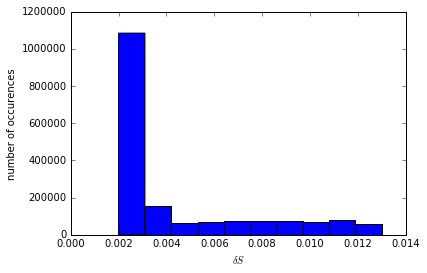

In [7]:
dS = sal_abs-sal_ref
plt.hist(dS.flatten())
plt.xlabel('$\delta S$')
plt.ylabel('number of occurences')

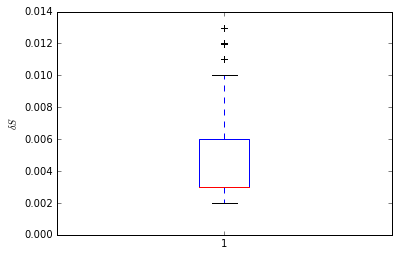

In [8]:
plt.boxplot(dS.flatten())
plt.ylabel('$\delta S$')

This is probably not very significant. We've decided to use $\delta S = 0$. 

# Conservative Temperature vs Potential Temperature

In [9]:
CT = gsw_calls.call_CT_from_PT(sal_abs, temp_pot)

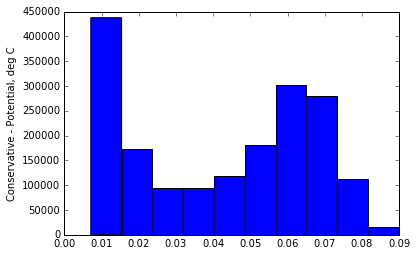

In [10]:
diff=CT-temp_pot
plt.hist(diff.flatten())
plt.ylabel(('Conservative - Potential, deg C'))

Looks like the differences aren't super big for boundary.

# Matlab Reference Salinity vs ours

Note: This comparison wes performed before the boundary files were overwritten.

In [16]:
def call_SR_from_SP(SP):
    
    fname ="'SRout'"
    SPfile= "'SPfile'"
    for f, var in zip([SPfile,],
                       [SP,]):
        np.savetxt(f[1:-1],var.flatten(), delimiter=',')
    shape = SP.shape
    
    functioncall = 'mw_gsw_SR_from_SP({},{});exit'.format(fname, SPfile)
    cmd = ["matlab", "-nodesktop", "-nodisplay", "-r", functioncall]
    sp.run(cmd)
    SR = np.loadtxt(fname[1:-1], delimiter=',')
    
    for f in [fname, SPfile]:
        os.remove(f[1:-1])
    
    return SR.reshape(shape)

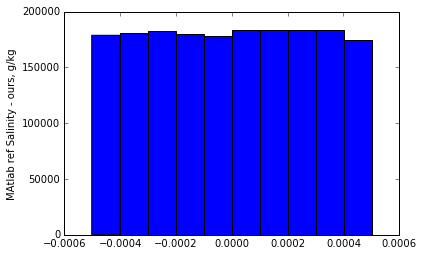

In [19]:
sal_ref_matlab = call_SR_from_SP(sal_pract)
diff = sal_ref_matlab - sal_ref
plt.hist(diff.flatten())
plt.ylabel('MAtlab ref Salinity - ours, g/kg')